# Custom finite difference coefficients in Devito

## Introduction

When taking the numerical derivative of a function in Devito, the default behaviour is for 'standard' finite difference weights (obtained via a Taylor series expansion about the point of differentiation) to be applied. Consider the following example for some field $u(\mathbf{x},t)$, where $\mathbf{x}=(x,y)$. Let us define a computational domain/grid and differentiate our field with respect to $x$.

In [1]:
import numpy as np
from devito import Grid, TimeFunction

# Create our grid (computational domain)
Lx = 10
Ly = Lx
Nx = 11
Ny = Nx
dx = Lx/(Nx-1)
dy = dx
grid = Grid(shape=(Nx,Ny), extent=(Lx,Ly))

# Define u(x,y,t) on this grid
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)

Now, lets look at the output of $\partial u/\partial x$:

In [2]:
print(u.dx)

Derivative(u(t, x, y), x)


By default the 'standard' Taylor series expansion result, where `h_x` represents the $x$-direction grid spacing, is returned. However, there may be instances when a user wishes to use 'non-standard' weights when, for example, implementing a dispersion-relation-preserving (DRP) scheme. See e.g. 

[1] Christopher K.W. Tam, Jay C. Webb (1993). ”Dispersion-Relation-Preserving Finite Difference Schemes for Computational Acoustics.” **J. Comput. Phys.**, 107(2), 262--281. https://doi.org/10.1006/jcph.1993.1142

for further details. The use of such modified weights is facilitated in Devito via the 'symbolic' finite difference coefficents functionality. Let us start by re-defining the function $u(\mathbf{x},t)$ in the following manner:

In [3]:
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2, coefficients='symbolic')

Note the addition of the `coefficients='symbolic'` keyword. Now, when printing $\partial u/\partial x$ we obtain:

In [4]:
print(u.dx)

Derivative(u(t, x, y), x)


Owing to the addition of the `coefficients='symbolic'` keyword the weights have been replaced by sympy functions. Now, take for example the weight `W(x - h_x, 1, u(t, x, y), x)`, the notation is as follows:
* The first `x - h_x` refers to the spatial location of the weight w.r.t. the evaluation point `x`.
* The `1` refers to the order of the derivative.
* `u(t, x, y)` refers to the function with which the weight is associated.
* Finally, the `x` refers to the dimension along which the derivative is being taken.

Symbolic coefficients can then be manipulated using the Devito 'Coefficient' and 'Substitutions' objects. First, let us consider an example where we wish to replace the coefficients with a set of constants throughout the entire computational domain.

In [5]:
from devito import Coefficient, Substitutions # Import the Devito Coefficient and Substitutions objects
# Grab the grid spatial dimensions: Note x[0] will correspond to the x-direction and x[1] to y-direction
x = grid.dimensions 
# Form a Coefficient object and then a replacement rules object (to pass to a Devito equation):
u_x_coeffs = Coefficient(1, u, x[0], np.array([-0.6, 0.1, 0.6]))
coeffs = Substitutions(u_x_coeffs)

Devito Coefficient ojects take arguments in the following order:
1. Derivative order (in the above example this is the first derivative)
2. Function to which the coefficients 'belong' (in the above example this is the time function `u`)
3. Dimension on which coefficients will be applied (in the above example this is the x-direction)
4. Coefficient data. Since, in the above example, the coefficients have been applied as a 1-d numpy array replacement will occur at the equation level. (Note that other options are in development and will be the subject of future notebooks).

Now, lets form a Devito equation, pass it the Substitutions object, and take a look at the output:

In [6]:
from devito import Eq
eq = Eq(u.dt+u.dx, coefficients=coeffs)
print(eq)

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), t), 0)


We see that in the above equation the standard weights for the first derivative of `u` in the $x$-direction have now been replaced with our user defined weights. Note that since no replacement rules were defined for the time derivative (`u.dt`) standard weights have replaced the symbolic weights.

Now, let us consider a more complete example.

## Example: Finite difference modeling for a large velocity-contrast acousitc wave model

It is advised to read through the 'Introduction to seismic modelling' notebook located in  devito/examples/seismic/tutorials/01_modelling.ipynb before proceeding with this example since much introductory material will be ommited here. The example now considered is based on an example introduced in

[2] Yang Liu (2013). ”Globally optimal finite-difference schemes based on least squares.” **GEOPHYSICS**, 78(4), 113--132. https://doi.org/10.1006/jcph.1993.1142.

See figure 18 of [2] for further details. Note that here we will simply use Devito to 'reproduce' the simulations leading to two results presented in the aforementioned figure. No analysis of the results will be carried out. The domain under consideration has a sptaial extent of $2km \times 2km$ and, letting $x$ be the horizontal coordinate and $z$ the depth, a velocity profile such that $v_1(x,z)=1500ms^{-1}$ for $z\leq1200m$ and $v_2(x,z)=4000ms^{-1}$ for $z>1200m$.



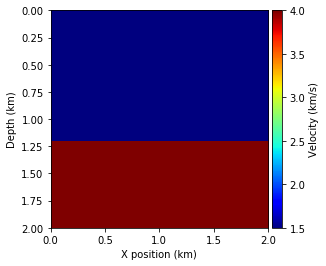

In [7]:
from examples.seismic import Model, plot_velocity
%matplotlib inline

# Define a physical size
Lx = 2000
Lz = Lx
h = 10
Nx = int(Lx/h)+1
Nz = Nx

shape = (Nx, Nz)  # Number of grid point
spacing = (h, h)  # Grid spacing in m. The domain size is now 2km by 2km
origin = (0., 0.)

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :121] = 1.5
v[:, 121:] = 4.0

# With the velocity and model size defined, we can create the seismic model that
# encapsulates these properties. We also define the size of the absorbing layer as 10 grid points
nbpml = 10
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=20, nbpml=nbpml)

plot_velocity(model)

The seismic wave source term will be modelled as a Ricker Wavelet with a peak-frequency of $25$Hz located at $(1000m,800m)$. Before applying the DRP scheme, we begin by generating a 'reference' solution using a spatially high-order standard finite difference scheme and time step well below the model's critical time-step. The scheme will be 2nd order in time.

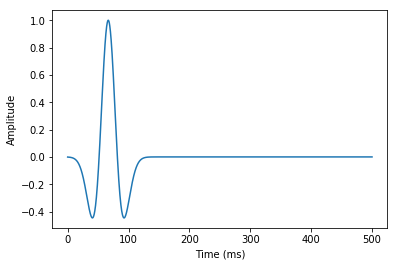

In [8]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation lasts 0.5 seconds (500 ms)
dt = 0.2  # Time step of 0.2ms

time_range = TimeAxis(start=t0, stop=tn, step=dt)

#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.015  # Source peak frequency is 25Hz (0.025 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 800.  # Depth is 800m

# We can plot the time signature to see the wavelet
src.show()

Now let us define our wavefield and PDE:

In [9]:
# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=20)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [10]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

Now, lets create the operator and execute the time marching scheme:

In [11]:
from devito import Operator

op = Operator([stencil] + src_term, subs=model.spacing_map)

In [12]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=dt)

Operator `Kernel` run in 0.22 s


And plot the result:

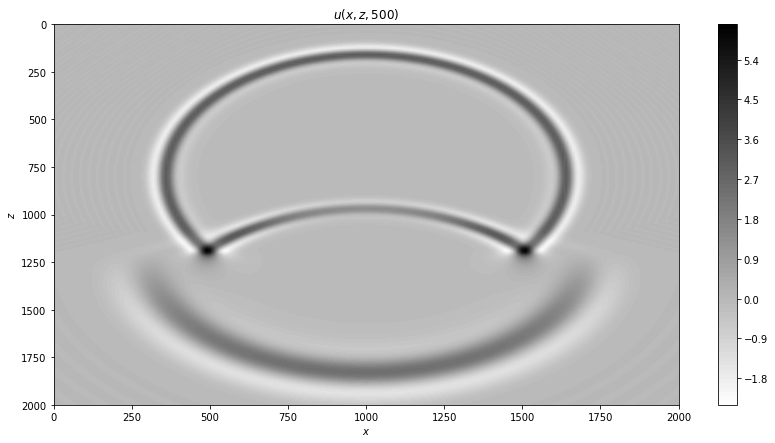

In [13]:
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

Lx = 2000
Lz = 2000

abs_lay = nbpml*h

dx = h
dz = dx
X, Z = np.mgrid[-abs_lay: Lx+abs_lay+1e-10: dx, -abs_lay: Lz+abs_lay+1e-10: dz]

levels = 100

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111)
cont = ax1.contourf(X,Z,u.data[0,:,:], levels, cmap=cm.binary)
fig.colorbar(cont)
ax1.axis([0, Lx, 0, Lz])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$z$')
ax1.set_title('$u(x,z,500)$')

plt.gca().invert_yaxis()
plt.show()

We will now reimplement the above model applying the DRP scheme presented in [2].

First, since we wish to apply different custom FD coefficients in the upper on lower layers we need to define these two 'subdomains' using the `Devito SubDomain` functionality:

In [14]:
from devito import SubDomain

# Define our 'upper' and 'lower' SubDomains:
class Upper(SubDomain):
    name = 'upper'
    def define(self, dimensions):
        x, z = dimensions
        # We want our upper layer to span the entire x-dimension and all
        # but the bottom 80 (+boundary layer) cells in the z-direction, which is achieved via
        # the following notation:
        return {x: x, z: ('left', 80+nbpml)}
    
class Lower(SubDomain):
    name = 'lower'
    def define(self, dimensions):
        x, z = dimensions
        # We want our lower layer to span the entire x-dimension and all
        # but the top 121 (+boundary layer) cells in the z-direction.
        return {x: x, z: ('right', 121+nbpml)}

# Create these subdomains:
ur = Upper()
lr = Lower()

We now create our model incoporating these subdomains:

In [15]:
# Our scheme will now be 10th order (or less) in space.
order = 10

# Create our model passing it our 'upper' and 'lower' subdomains: 
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=order, nbpml=nbpml, subdomains=(ur,lr))

And re-define model related objects. Note that now our wave-field will be defined with `coefficients='symbolic'`.

In [16]:
t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation last 1 second (500 ms)
dt = 1.0  # Time step of 1.0ms

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 800.  # Depth is 800m

# New wave-field
u_DRP = TimeFunction(name="u_DRP", grid=model.grid, time_order=2, space_order=order, coefficients='symbolic')

We now create a stencil for each of our 'Upper' and 'Lower' subdomains defining different custom FD weights within each of these subdomains.

In [17]:
# The underlying pde is the same in both subdomains
pde_DRP = model.m * u_DRP.dt2 - u_DRP.laplace + model.damp * u_DRP.dt

# Define our custom FD coefficients:
x, z = model.grid.dimensions
# Upper layer
weights_u = np.array([ 2.00462e-03, -1.63274e-02,  7.72781e-02, 
                      -3.15476e-01,  1.77768e+00, -3.05033e+00,  
                       1.77768e+00, -3.15476e-01,  7.72781e-02, 
                      -1.63274e-02,  2.00462e-03])
# Lower layer
weights_l = np.array([  0.      ,  0.      ,  0.0274017, 
                       -0.223818,  1.64875 , -2.90467,  
                        1.64875 , -0.223818,  0.0274017,  
                        0.      ,  0.       ])
# Create the Devito Coefficient objects:
ux_u_coeffs = Coefficient(2, u_DRP, x, weights_u/x.spacing**2)
uz_u_coeffs = Coefficient(2, u_DRP, z, weights_u/z.spacing**2)
ux_l_coeffs = Coefficient(2, u_DRP, x, weights_l/x.spacing**2)
uz_l_coeffs = Coefficient(2, u_DRP, z, weights_l/z.spacing**2)
# And the replacement rules:
coeffs_u = Substitutions(ux_u_coeffs,uz_u_coeffs)
coeffs_l = Substitutions(ux_l_coeffs,uz_l_coeffs)
# Create a stencil for each subdomain:
stencil_u = Eq(u_DRP.forward, solve(pde_DRP, u_DRP.forward), subdomain = model.grid.subdomains['upper'],
               coefficients=coeffs_u)
stencil_l = Eq(u_DRP.forward, solve(pde_DRP, u_DRP.forward), subdomain = model.grid.subdomains['lower'],
               coefficients=coeffs_l)

# Source term:
src_term = src.inject(field=u_DRP.forward, expr=src * dt**2 / model.m)

# Create the operator, incoporating both upper and lower stencils:
op = Operator([stencil_u, stencil_l] + src_term, subs=model.spacing_map)

And now execute the operator:

In [18]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=dt)

Operator `Kernel` run in 0.01 s


And plot the new results:

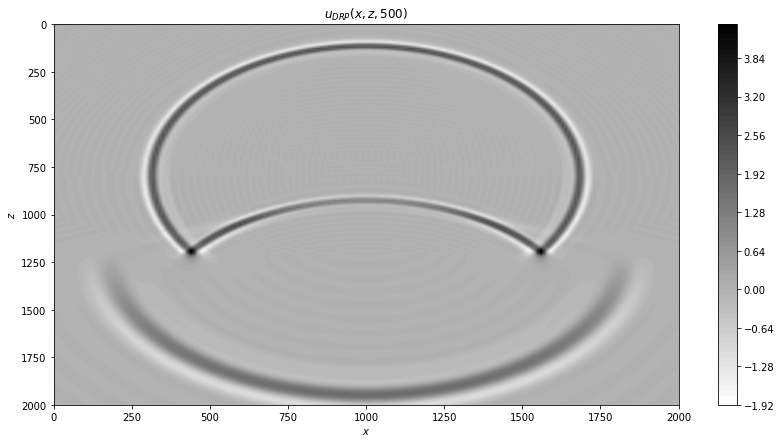

In [19]:
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111)
cont = ax1.contourf(X,Z,u_DRP.data[0,:,:], levels, cmap=cm.binary)
fig.colorbar(cont)
ax1.axis([0, Lx, 0, Lz])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$z$')
ax1.set_title('$u_{DRP}(x,z,500)$')

plt.gca().invert_yaxis()
plt.show()

Finally, for comparison, lets plot the difference between the standard 20th order and optimized 10th order models:

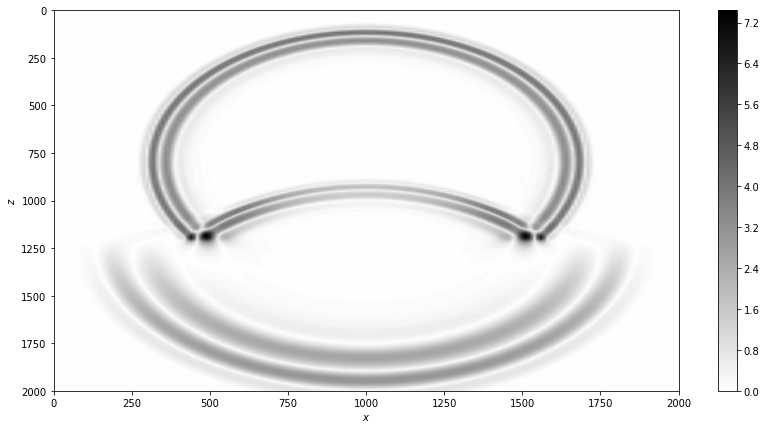

In [20]:
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111)
cont = ax1.contourf(X,Z,abs(u_DRP.data[0,:,:]-u.data[0,:,:]), levels, cmap=cm.binary)
fig.colorbar(cont)
ax1.axis([0, Lx, 0, Lz])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$z$')

plt.gca().invert_yaxis()
plt.show()